Goal: Use historical power consumption data to forecast consumption for the next year.
Data: The dataset used is from the UC Irvine Machine Learning Repository: [Individual household electric power consumption](https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption). The electric power consumption of a household in France was recorded every minute from 2006 to 2010.

Tasks can be divided into two parts:
#### Part A: Display Historical and Forecast Data
1. Apply the Prophet model to forecast power consumption for the next 365 days.
2. Extract the date and time, and power consumption information.
3. Calculate the daily sum from the minute data.
4. Use all daily sums to forecast the next 365 days.

#### Part B: Evaluate the Model Performance
1. Subset the first two full years of data (2007-2008) and then use them to forecast the next year.
2. Compare the actual 2009 data with the forecasted data.

Part A:

In [ ]:
# Set-up
# comment if packages installed
#!pip install prophet pandas matplotlib

In [3]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
df = pd.read_csv(url, sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan', '?'])

# Display the first few rows
print(df.head())

<ipython-input-3-781023f91022>:8: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(url, sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan', '?'])
<ipython-input-3-781023f91022>:8: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(url, sep=';', parse_dates={'datetime': ['Date', 'Time']}, infer_datetime_format=True, low_memory=False, na_values=['nan', '?'])


             datetime  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16 17:24:00                4.216                  0.418   234.84   
1 2006-12-16 17:25:00                5.360                  0.436   233.63   
2 2006-12-16 17:26:00                5.374                  0.498   233.29   
3 2006-12-16 17:27:00                5.388                  0.502   233.74   
4 2006-12-16 17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  


In [4]:
# Select and preprocess the data
df = df[['datetime', 'Global_active_power']].dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)

In [5]:
# turn datetime column to row index, inplace = True: operation done on df
df.set_index('datetime',inplace = True)

In [6]:
# calculate daily sum
daily_df = df.resample('D').sum()

# reset index to get 'datetime' back as a column
daily_df.reset_index(inplace = True)
print(daily_df.head())

    datetime  Global_active_power
0 2006-12-16             1209.176
1 2006-12-17             3390.460
2 2006-12-18             2203.826
3 2006-12-19             1666.194
4 2006-12-20             2225.748


In [7]:
# Rename columns
daily_df.columns = ['ds', 'y']

# Display the first few rows
print(daily_df.head())

          ds         y
0 2006-12-16  1209.176
1 2006-12-17  3390.460
2 2006-12-18  2203.826
3 2006-12-19  1666.194
4 2006-12-20  2225.748


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcclc4267/zfzd66ek.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcclc4267/5u0d5ufb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48750', 'data', 'file=/tmp/tmpcclc4267/zfzd66ek.json', 'init=/tmp/tmpcclc4267/5u0d5ufb.json', 'output', 'file=/tmp/tmpcclc4267/prophet_modelxlsipgx8/prophet_model-20240618194245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:42:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:42:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds         yhat   yhat_lower   yhat_upper
1802 2011-11-22  1977.776420  1406.146908  2559.969244
1803 2011-11-23  1994.773703  1414.039654  2563.705219
1804 2011-11-24  1849.716207  1250.461753  2407.106631
1805 2011-11-25  1944.700465  1366.763531  2491.731260
1806 2011-11-26  2195.353096  1623.741778  2736.662641


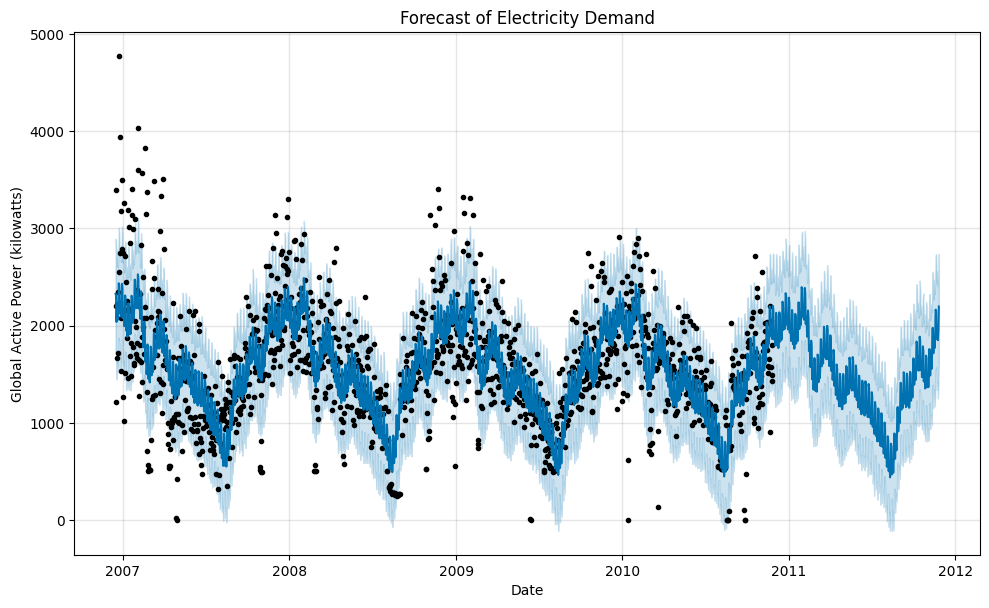

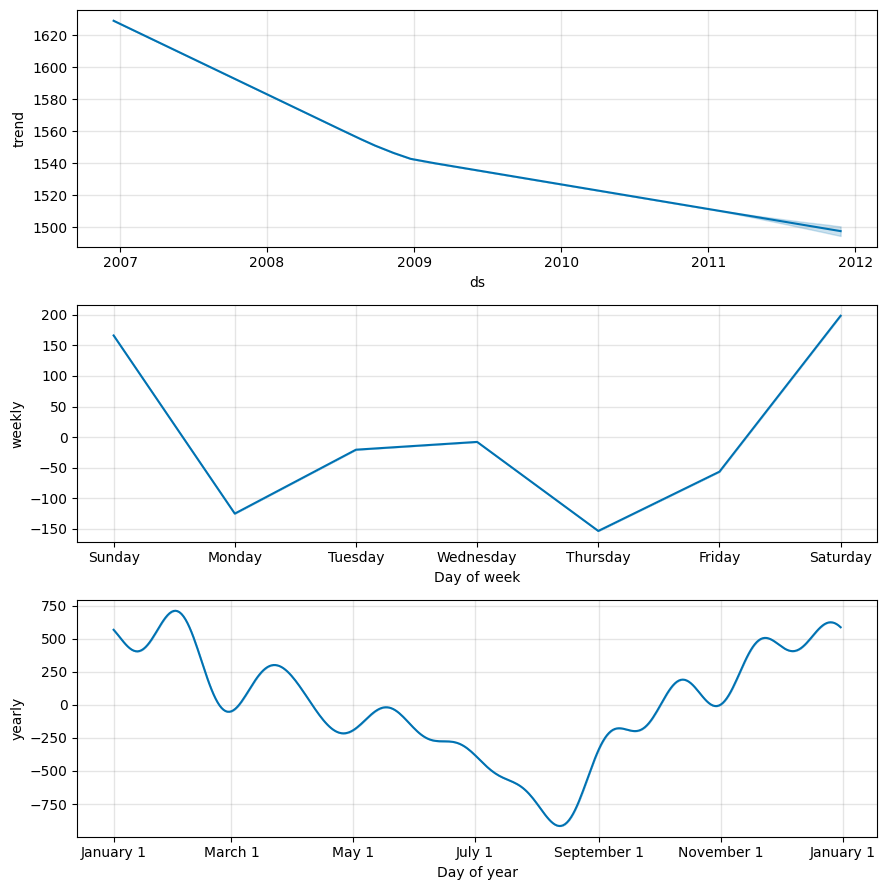

In [8]:
# Create and train the Prophet model
model = Prophet()
model.fit(daily_df)

# Make future predictions
future = model.make_future_dataframe(periods=365, freq='D')  # Predicting daily demand for the next year
forecast = model.predict(future)

# Display the predictions
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Plot the forecast
fig = model.plot(forecast)
plt.title('Forecast of Electricity Demand')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.show()

# Plot the forecast components
fig2 = model.plot_components(forecast)
plt.show()

The plot shows clear seasonal variability with maximum power consumption in winter and minimum in summer. While not as noticeable as the seasonal variability, the forecast component plot shows weekly variability with a maximum on weekends and a mild trend.

Part B:

In [40]:
# Filter data for the years 2007 and 2008
train_df = daily_df[(daily_df['ds'] >= '2007-01-01') & (daily_df['ds'] <= '2008-12-31')]
test_df = daily_df[(daily_df['ds'] >= '2009-01-01') & (daily_df['ds'] <= '2009-12-31')]

# Display the first few rows of the training and testing sets
print("Training data:")
print(train_df.head())
print("Testing data:")
print(test_df.head())
print(len(train_df))

Training data:
           ds         y
16 2007-01-01  2749.004
17 2007-01-02  1269.236
18 2007-01-03  1014.054
19 2007-01-04  3259.412
20 2007-01-05  2713.364
Testing data:
            ds         y
747 2009-01-01  1406.692
748 2009-01-02  2327.510
749 2009-01-03  1913.496
750 2009-01-04  1939.994
751 2009-01-05  1604.000
731


In [41]:
# Consider the effect of holidays (optional)
#holidays = pd.DataFrame({
#  'holiday': 'holiday_name',
#  'ds': pd.to_datetime(['2007-12-25', '2008-01-01', '2008-12-25', '2009-01-01']),
#  'lower_window': 0,
#  'upper_window': 1,
#})
#model = Prophet(holidays=holidays, yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Create and train the Prophet model with the training set
model = Prophet()
model.fit(train_df)

# Make future predictions for 2008
future = model.make_future_dataframe(periods=365, freq='D')
forecast = model.predict(future)
print(forecast.tail())

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqt1mwy4/x996agkv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoqt1mwy4/y0i7cenl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85296', 'data', 'file=/tmp/tmpoqt1mwy4/x996agkv.json', 'init=/tmp/tmpoqt1mwy4/y0i7cenl.json', 'output', 'file=/tmp/tmpoqt1mwy4/prophet_modelqvt7hrpt/prophet_model-20240618171532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:15:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:15:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


             ds        trend   yhat_lower   yhat_upper  trend_lower  \
1091 2009-12-27  1302.083452  1563.986109  2777.414698  1277.333718   
1092 2009-12-28  1301.630345  1138.296187  2336.265445  1276.725616   
1093 2009-12-29  1301.177238  1323.219276  2513.138876  1276.117514   
1094 2009-12-30  1300.724132  1295.384324  2482.926663  1275.510993   
1095 2009-12-31  1300.271025  1133.857836  2338.349881  1274.906240   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
1091  1323.924626      847.915689            847.915689            847.915689   
1092  1323.575326      457.172970            457.172970            457.172970   
1093  1323.277264      607.391859            607.391859            607.391859   
1094  1322.979202      586.729453            586.729453            586.729453   
1095  1322.674144      442.379278            442.379278            442.379278   

          weekly  weekly_lower  weekly_upper      yearly  yearly_lower  \
1091  235.42

Mean Absolute Error (MAE): 274.7760477873651
Mean Squared Error (MSE): 129606.77235938012


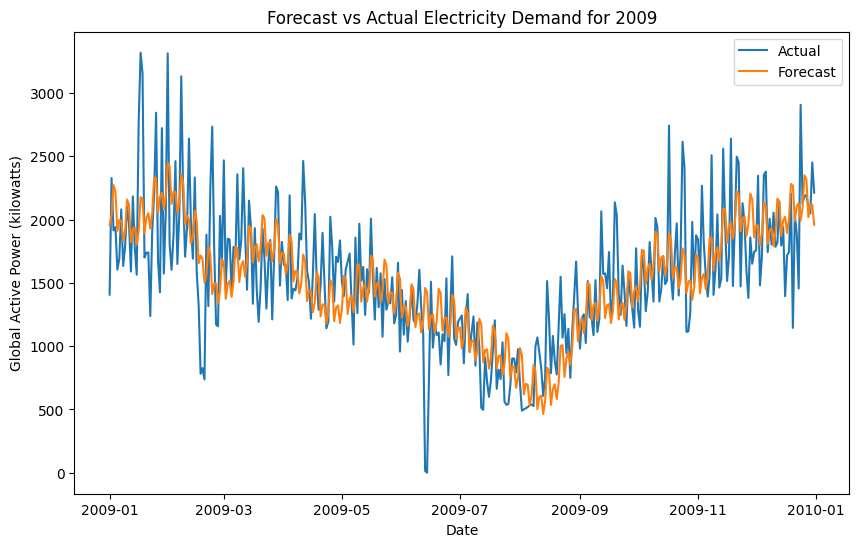

In [45]:
# Extract the forecasted values for 2009
forecast_2009 = forecast[(forecast['ds'] >= '2009-01-01') & (forecast['ds'] <= '2009-12-31')][['ds', 'yhat']].reset_index(drop=True)
actual_2009 = test_df[['ds', 'y']].reset_index(drop=True)

# merge by dates as actual has 366 days, while forecast has 366 days
df_merge = pd.merge(actual_2009, forecast_2009, on = 'ds', how = 'inner')

mae = mean_absolute_error(df_merge['y'], df_merge['yhat'])
mse = mean_squared_error(df_merge['y'], df_merge['yhat'])
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')

# Plot the forecast against the actual values
plt.figure(figsize=(10, 6))
plt.plot(df_merge['ds'], df_merge['y'], label='Actual')
plt.plot(df_merge['ds'], df_merge['yhat'], label='Forecast')
plt.title('Forecast vs Actual Electricity Demand for 2009')
plt.xlabel('Date')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()
plt.show()

The seasonal variability is captured, while the extreme consumption in the forecast is far less than the observations. The longer the years in training, the better the model performs. While not showing, using just one year of data for training, the upward trend from summer to winter outweighs other variability, leading to the forecast next year with a linear trend.